In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
import tensorflow as tf
from tensorflow import keras
layers = keras.layers
Lambda = keras.layers.Lambda
Model = keras.Model
Sequential=keras.models.Sequential
MeanSquaredError=keras.losses.MeanSquaredError
Precision=keras.metrics.Precision
Recall=keras.metrics.Recall
MeanAbsoluteError=keras.metrics.MeanAbsoluteError
MeanAbsolutePercentageError=keras.metrics.MeanAbsolutePercentageError
SparseCategoricalCrossentropy=keras.metrics.SparseCategoricalCrossentropy
RootMeanSquaredError=keras.metrics.RootMeanSquaredError
Dense=keras.layers.Dense
InputLayer=keras.layers.InputLayer
Input=keras.layers.Input
LSTM=keras.layers.LSTM
ModelCheckpoint=keras.callbacks.ModelCheckpoint
Adam=keras.optimizers.Adam
load_model=keras.models.load_model
import tensorflow_addons as tfa
F1Score=tfa.metrics.F1Score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def setup_spark_session():
    """Configurar Spark para procesar 169M+ registros"""
    spark = (
        SparkSession.builder
        .appName("UTD19_BigData_TrafficPrediction")
        .config("spark.driver.memory", "4g")
        .config("spark.executor.memory", "12g")
        .config("spark.executor.cores", "2")
        .config("spark.executor.instances", "2")
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
        .config("spark.sql.adaptive.advisoryPartitionSizeInBytes", "64MB")
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")
        .getOrCreate()
    )
    
    
    print(f"✅ Spark configurado - Versión: {spark.version}")
    print(f"📊 Configuración: 8 executors, 16GB memoria cada uno")
    return spark

In [3]:
class UTD19_ETL_Pipeline:
    """Pipeline ETL completo para dataset UTD19 (134M+ registros)"""
    
    def __init__(self, spark_session):
        self.spark = spark_session
        self.quality_metrics = {}
        
    def run_complete_etl(self, input_path="./data/raw/", output_path="./data/processed/"):
        """Ejecutar ETL completo: Extract -> Transform -> Load"""
        print("=" * 60)
        print("🚀 INICIANDO ETL PIPELINE COMPLETO UTD19")
        print("=" * 60)
        
        # EXTRACT
        raw_datasets = self.extract_raw_data(input_path)
        
        # TRANSFORM
        clean_datasets = self.transform_data(raw_datasets)
        
        # LOAD
        self.load_clean_data(clean_datasets, output_path)
        
        # QUALITY REPORT
        self.generate_quality_report()
        
        return clean_datasets
    
    def extract_raw_data(self, input_path):
        """Extracción de datos con validación inicial"""
        print("\n📥 FASE 1: EXTRACCIÓN DE DATOS")
        print("-" * 40)
        
        # Cargar datasets principales
        print("🔄 Cargando detectores...")
        detectors_df = self.spark.read \
            .option("header", "true") \
            .option("inferSchema", "false") \
            .csv(f"{input_path}detectors_public.csv")
        
        print("🔄 Cargando links...")
        links_df = self.spark.read \
            .option("header", "true") \
            .option("inferSchema", "false") \
            .csv(f"{input_path}links.csv")
        
        print("🔄 Cargando UTD19 principal (puede tomar varios minutos)...")
        utd19_df = self.spark.read \
            .option("header", "true") \
            .option("inferSchema", "false") \
            .csv(f"{input_path}utd19_u.csv") \
            .repartition(400, "city", "detid")  # Optimizar particionado
        
        # Estadísticas iniciales
        detectors_count = detectors_df.count()
        links_count = links_df.count()
        utd19_count = utd19_df.count()
        
        print(f"✅ Detectores: {detectors_count:,} registros")
        print(f"✅ Links: {links_count:,} registros") 
        print(f"✅ UTD19: {utd19_count:,} registros")
        
        self.quality_metrics['raw_counts'] = {
            'detectors': detectors_count,
            'links': links_count,
            'utd19': utd19_count
        }
        
        return {'detectors': detectors_df, 'links': links_df, 'utd19': utd19_df}
    
    def transform_data(self, raw_datasets):
        """Transformaciones de limpieza y enriquecimiento"""
        print("\n🔧 FASE 2: TRANSFORMACIÓN DE DATOS")
        print("-" * 40)
        
        # 1. Limpieza de tipos de datos
        print("📋 Paso 1: Enforcement de tipos de datos...")
        clean_datasets = self._enforce_data_types(raw_datasets)
        
        # 2. Validación de reglas de negocio
        print("✅ Paso 2: Aplicación de reglas de negocio...")
        validated_datasets = self._apply_business_rules(clean_datasets)
        
        # 3. Tratamiento de valores faltantes
        print("🔧 Paso 3: Tratamiento de valores faltantes...")
        imputed_datasets = self._handle_missing_values(validated_datasets)
        
        # 4. Detección y tratamiento de outliers
        print("📊 Paso 4: Detección de outliers...")
        final_datasets = self._detect_and_handle_outliers(imputed_datasets)
        
        # 5. Enriquecimiento con features derivados
        print("🎯 Paso 5: Creación de features derivados...")
        enriched_datasets = self._create_derived_features(final_datasets)
        
        return enriched_datasets
    
    def _enforce_data_types(self, datasets):
        """Conversión robusta de tipos de datos"""
        print("   🔄 Convirtiendo tipos de datos...")
        
        # Esquema para UTD19 principal
        utd19_schema = {
            'detid': 'double',
            'city': 'string', 
            'day': 'string',
            'interval': 'double',
            'flow': 'double',
            'speed': 'double',
            'occ': 'double',
            'error': 'string'
        }
        
        # Esquema para detectores
        detectors_schema = {
            'detid': 'double',
            'citycode': 'string',
            'lat': 'double',
            'long': 'double', 
            'lanes': 'double',
            'pos': 'double',
            'limit': 'double',
            'length': 'double',
            'linkid': 'double',
            'fclass': 'string',
            'road': 'string'
        }
        
        # Aplicar schemas con try_cast para robustez
        clean_utd19 = self._apply_schema_robust(datasets['utd19'], utd19_schema)
        clean_detectors = self._apply_schema_robust(datasets['detectors'], detectors_schema)
        
        # Links mantener como está por simplicidad
        clean_links = datasets['links']
        
        return {
            'utd19': clean_utd19,
            'detectors': clean_detectors, 
            'links': clean_links
        }
    
    def _apply_schema_robust(self, df, schema):
        """Aplicar schema con manejo robusto de errores - CORREGIDO"""
        for column, data_type in schema.items():
            if column in df.columns:
                if data_type == 'int':
                    # Para enteros: convertir a double primero, luego a int
                    df = df.withColumn(column, 
                        when(col(column).isNull(), lit(None))
                        .when(col(column).rlike("^-?[0-9]*\\.?[0-9]+$"), 
                            col(column).cast("double").cast("int"))
                        .otherwise(lit(None))
                    )
                elif data_type == 'double':
                    # Para doubles: usar regex más permisivo
                    df = df.withColumn(column, 
                        when(col(column).isNull(), lit(None))
                        .when(col(column).rlike("^-?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?$"),
                            col(column).cast("double"))
                        .otherwise(lit(None))
                    )
                else:
                    # Para strings, solo limpiar espacios
                    df = df.withColumn(column, 
                        when(col(column).isNull(), lit(None))
                        .otherwise(trim(col(column)))
                    )
        return df
    
    def _apply_business_rules(self, datasets):
        """Aplicar reglas de negocio específicas del dominio"""
        print("   🎯 Aplicando reglas de negocio de tráfico...")
        
        utd19_df = datasets['utd19']
        
        # Reglas de validación para datos de tráfico
        validated_utd19 = utd19_df.filter(
            # Flow: 0 a 15,000 vehículos/hora (máximo teórico autopista)
            (col("flow").isNull() | col("flow").between(0, 15000)) &
            
            # Speed: 0 a 200 km/h (máximo razonable urbano/autopista)
            (col("speed").isNull() | col("speed").between(0, 200)) &
            
            # Occupancy: 0 a 1.0 (ratio de ocupación)
            (col("occ").isNull() | col("occ").between(0, 1.0)) &
            
            # Interval: 0 a 86400 segundos (24 horas)
            (col("interval").isNull() | col("interval").between(0, 86400)) &
            
            # Detid debe ser positivo
            (col("detid").isNotNull() & (col("detid") > 0))
        )
        
        # Validaciones para detectores
        detectors_df = datasets['detectors'] 
        validated_detectors = detectors_df.filter(
            # Coordenadas válidas
            (col("lat").isNull() | col("lat").between(-90, 90)) &
            (col("long").isNull() | col("long").between(-180, 180)) &
            
            # Lanes: 1 a 10 carriles (máximo razonable)
            (col("lanes").isNull() | col("lanes").between(1, 10)) &
            
            # Position: 0 a 1 (posición en link)
            (col("pos").isNull() | col("pos").between(0, 1)) &
            
            # Speed limit: 10 a 200 km/h
            (col("limit").isNull() | col("limit").between(10, 200))
        )
        
        # Calcular métricas de calidad
        original_utd19_count = utd19_df.count()
        validated_utd19_count = validated_utd19.count()
        
        validation_rate = validated_utd19_count / original_utd19_count
        
        print(f"   ✅ Registros válidos: {validated_utd19_count:,} de {original_utd19_count:,}")
        print(f"   📊 Tasa de validación: {validation_rate:.2%}")
        
        self.quality_metrics['validation_rate'] = validation_rate
        
        return {
            'utd19': validated_utd19,
            'detectors': validated_detectors,
            'links': datasets['links']
        }
    
    def _handle_missing_values(self, datasets):
        """Estrategia de imputación para valores faltantes"""
        print("   🔧 Tratando valores faltantes...")
        
        utd19_df = datasets['utd19']
        
        # Estrategias específicas por variable
        # 1. Speed: Solo 3.4% completitud - imputar con velocidad límite cuando esté disponible
        utd19_df = utd19_df.join(datasets['detectors'].select("detid", col("limit").alias("detector_limit")), "detid", "left")
        
        utd19_imputed = utd19_df.withColumn(
            "speed_imputed",
            when(col("speed").isNotNull(), col("speed"))
            .when(col("detector_limit").isNotNull(), col("detector_limit") * 0.8)  # 80% del límite
            .otherwise(lit(50.0))  # Velocidad urbana promedio
        ).withColumn(
            "flow_imputed", 
            when(col("flow").isNotNull(), col("flow"))
            .otherwise(lit(500))  # Flow promedio urbano
        ).withColumn(
            "occ_imputed",
            when(col("occ").isNotNull(), col("occ"))
            .otherwise(lit(0.2))  # Ocupancy promedio
        )
        
        # Crear flags de imputación para trazabilidad
        utd19_final = utd19_imputed.withColumn(
            "speed_was_imputed", col("speed").isNull().cast("int")
        ).withColumn(
            "flow_was_imputed", col("flow").isNull().cast("int") 
        ).withColumn(
            "occ_was_imputed", col("occ").isNull().cast("int")
        ).drop("speed", "flow", "occ") \
         .withColumnRenamed("speed_imputed", "speed") \
         .withColumnRenamed("flow_imputed", "flow") \
         .withColumnRenamed("occ_imputed", "occ")
        
        return {
            'utd19': utd19_final,
            'detectors': datasets['detectors'],
            'links': datasets['links']
        }
    
    def _detect_and_handle_outliers(self, datasets):
        """Detección y tratamiento de outliers estadísticos"""
        print("   📊 Detectando outliers...")
        
        utd19_df = datasets['utd19']
        
        # Calcular percentiles para detección de outliers
        flow_stats = utd19_df.select(
            expr("percentile_approx(flow, 0.01)").alias("flow_p1"),
            expr("percentile_approx(flow, 0.99)").alias("flow_p99")
        ).collect()[0]
        
        speed_stats = utd19_df.select(
            expr("percentile_approx(speed, 0.01)").alias("speed_p1"), 
            expr("percentile_approx(speed, 0.99)").alias("speed_p99")
        ).collect()[0]
        
        # Aplicar winsorización (cap outliers a percentiles)
        utd19_clean = utd19_df.withColumn(
            "flow_clean",
            when(col("flow") < flow_stats['flow_p1'], lit(flow_stats['flow_p1']))
            .when(col("flow") > flow_stats['flow_p99'], lit(flow_stats['flow_p99']))
            .otherwise(col("flow"))
        ).withColumn(
            "speed_clean", 
            when(col("speed") < speed_stats['speed_p1'], lit(speed_stats['speed_p1']))
            .when(col("speed") > speed_stats['speed_p99'], lit(speed_stats['speed_p99']))
            .otherwise(col("speed"))
        ).drop("flow", "speed") \
         .withColumnRenamed("flow_clean", "flow") \
         .withColumnRenamed("speed_clean", "speed")
        
        return {
            'utd19': utd19_clean,
            'detectors': datasets['detectors'],
            'links': datasets['links']
        }
    
    def _create_derived_features(self, datasets):
        """Crear features derivados para ML"""
        print("   🎯 Creando features derivados...")
        
        utd19_df = datasets['utd19']
        detectors_df = datasets['detectors']
        
        # Join principal
        enhanced_df = utd19_df.join(detectors_df, "detid", "left")
        
        # Features temporales
        enhanced_df = enhanced_df.withColumn(
            "hour_of_day", (col("interval") / 3600).cast("int")
        ).withColumn(
            "day_of_week", dayofweek(to_date(col("day"), "yyyy-MM-dd"))
        ).withColumn(
            "is_weekend", when(col("day_of_week").isin([1, 7]), 1).otherwise(0)
        ).withColumn(
            "is_rush_hour",
            when(col("hour_of_day").between(7, 9) | col("hour_of_day").between(17, 19), 1).otherwise(0)
        )
        
        # Features de tráfico
        enhanced_df = enhanced_df.withColumn(
            "speed_ratio",
            when(col("limit") > 0, least(col("speed") / col("limit"), lit(2.0))).otherwise(1.0)
        ).withColumn(
            "congestion_level",
            when(col("speed_ratio") >= 0.8, 0)
            .when(col("speed_ratio") >= 0.6, 1) 
            .when(col("speed_ratio") >= 0.4, 2)
            .when(col("speed_ratio") >= 0.2, 3)
            .otherwise(4)
        )
        
        # Features espaciales
        enhanced_df = enhanced_df.withColumn(
            "near_intersection", when(col("pos") <= 0.1, 1).otherwise(0)
        ).withColumn(
            "multi_lane", when(col("lanes") > 1, 1).otherwise(0)
        ).withColumn(
            "has_speed_limit", when(col("limit") > 0, 1).otherwise(0)
        )

        # features temporales derivadas
        w = Window.partitionBy("detid").orderBy("day","interval")
        enhanced_df = enhanced_df.withColumn("flow_lag_1", lag("flow", 1).over(w))
        enhanced_df = enhanced_df.withColumn("speed_trend", col("speed") - lag("speed", 1).over(w))
        
        # Cache para operaciones posteriores
        enhanced_df.cache()
        
        return {
            'utd19_ml_ready': enhanced_df,
            'detectors': datasets['detectors'],
            'links': datasets['links']
        }
    
    def load_clean_data(self, clean_datasets, output_path):
        """Persistir datos limpios - VERSION WINDOWS COMPATIBLE"""
        print(f"\n💾 FASE 3: CARGA DE DATOS LIMPIOS")
        print("-" * 40)
        
        # Guardar en CSV para evitar problemas de Hadoop en Windows
        print("🔄 Guardando dataset principal...")
        clean_datasets['utd19_ml_ready'].coalesce(10).write \
            .mode("overwrite") \
            .option("header", "true") \
            .csv(f"{output_path}utd19clean")

        print("🔄 Guardando detectores...")
        clean_datasets['detectors'].write \
            .mode("overwrite") \
            .option("header", "true") \
            .csv(f"{output_path}detectorsclean")

        print("🔄 Guardando links...")
        clean_datasets['links'].write \
            .mode("overwrite") \
            .option("header", "true") \
            .csv(f"{output_path}linksclean")
        
        print(f"✅ Datos guardados en: {output_path}")
    
    def generate_quality_report(self):
        """Generar reporte de calidad de datos"""
        print(f"\n📋 REPORTE DE CALIDAD DE DATOS")
        print("=" * 40)
        
        print(f"📊 Registros originales: {self.quality_metrics['raw_counts']['utd19']:,}")
        print(f"✅ Tasa de validación: {self.quality_metrics['validation_rate']:.2%}")
        
        # Calcular registros finales estimados
        final_estimated = int(self.quality_metrics['raw_counts']['utd19'] * self.quality_metrics['validation_rate'])
        print(f"🎯 Registros limpios estimados: {final_estimated:,}")
        
        reduction_rate = 1 - self.quality_metrics['validation_rate']
        print(f"📉 Reducción por limpieza: {reduction_rate:.2%}")
        
        if self.quality_metrics['validation_rate'] > 0.8:
            print("✅ CALIDAD: Excelente (>80% datos válidos)")
        elif self.quality_metrics['validation_rate'] > 0.6:
            print("⚠️ CALIDAD: Buena (>60% datos válidos)")
        else:
            print("🔴 CALIDAD: Requiere atención (<60% datos válidos)")

In [4]:
class SpatioTemporalLSTM(tf.keras.Model):
    def __init__(self, num_detectors, sequence_length=12, feature_dim=10):
        super().__init__()
        self.num_detectors = num_detectors
        self.sequence_length = sequence_length
        
        # Embedding espacial para detectores
        self.detector_embedding = layers.Embedding(
            input_dim=num_detectors + 1,  # +1 para detectores desconocidos
            output_dim=32,
            mask_zero=True,
            name="detector_embedding"
        )
        
        # Capas LSTM para modelado temporal
        self.lstm1 = layers.LSTM(
            128, 
            return_sequences=True, 
            dropout=0.2,
            recurrent_dropout=0.0,
            name="lstm_1"
        )
        self.lstm2 = layers.LSTM(
            64, 
            return_sequences=False,
            dropout=0.2,
            recurrent_dropout=0.0,
            name="lstm_2"
        )
        
        # Capas densas para procesamiento
        self.dense1 = Dense(64, activation='relu', name="dense_1")
        self.dropout1 = layers.Dropout(0.3)
        self.dense2 = Dense(32, activation='relu', name="dense_2")
        self.dropout2 = layers.Dropout(0.2)
        
        # Salidas múltiples
        self.flow_output = Dense(1, activation='linear', name='flow_prediction')
        self.congestion_output = Dense(2, activation='softmax', name='congestion_prediction')
    
    def call(self, inputs, training=None):
        # inputs: [temporal_features, detector_ids]
        temporal_features, detector_ids = inputs
        
        # Procesar embeddings espaciales
        detector_emb = self.detector_embedding(detector_ids)
        
        # Combinar features temporales con embeddings espaciales
        # temporal_features: [batch, sequence, features]
        # detector_emb: [batch, embedding_dim]
        detector_emb_expanded = tf.expand_dims(detector_emb, axis=1)
        detector_emb_tiled = tf.tile(detector_emb_expanded, [1, self.sequence_length, 1])
        
        combined_features = tf.concat([temporal_features, detector_emb_tiled], axis=-1)
        
        # Procesamiento LSTM
        lstm_out = self.lstm1(combined_features, training=training)
        lstm_out = self.lstm2(lstm_out, training=training)
        
        # Capas densas
        dense_out = self.dense1(lstm_out)
        dense_out = self.dropout1(dense_out, training=training)
        dense_out = self.dense2(dense_out)
        dense_out = self.dropout2(dense_out, training=training)
        
        # Predicciones
        flow_pred = self.flow_output(dense_out)
        congestion_pred = self.congestion_output(dense_out)
        
        return {
            'flow_prediction': flow_pred,
            'congestion_prediction': congestion_pred
        }

In [5]:
def prepare_traffic_prediction_data(ml_df_pandas, sequence_length=12, test_weeks=1):
    """
    División temporal específica para predicción de tráfico
    
    Args:
        ml_df_pandas: DataFrame con datos de tráfico
        sequence_length: Ventana temporal (12 intervalos = 1 hora si cada intervalo es 5min)
        test_weeks: Número de semanas para testing (simula predicción real)
    """
    
    print(f"🚦 PREPARANDO DATOS PARA PREDICCIÓN DE TRÁFICO")
    print(f"📊 Total de registros: {len(ml_df_pandas):,}")
    
    # ===== PASO 1: NORMALIZACIÓN (UNA SOLA VEZ) =====
    temporal_features = [
        'flow', 'speed', 'occ', 'hour_of_day', 'is_rush_hour',
        'flow_lag_1', 'speed_trend', 'lanes', 'pos', 'near_intersection',
        'length', 'has_speed_limit'
    ]
    

    scaler = StandardScaler()
    features_to_scale = temporal_features

    ml_df_pandas[features_to_scale] = ml_df_pandas[features_to_scale].fillna(0)
    
    # Normalizar (excepto flow que es nuestro target principal)
    ml_df_pandas[features_to_scale] = scaler.fit_transform(ml_df_pandas[features_to_scale])
    
    # ===== PASO 2: DIVISIÓN TEMPORAL REALISTA =====
    # Ordenar por tiempo (CRÍTICO para series temporales)
    ml_df_pandas = ml_df_pandas.sort_values(['day', 'interval']).reset_index(drop=True)
    
    # Calcular días de test (últimas semanas)
    unique_days = sorted(ml_df_pandas['day'].unique())
    test_days_count = test_weeks * 7  # días
    
    if test_days_count >= len(unique_days):
        test_days_count = max(1, len(unique_days) // 4)  # Mínimo 25% para test
    
    train_days = unique_days[:-test_days_count]
    test_days = unique_days[-test_days_count:]
    
    print(f"📅 Período de entrenamiento: días {train_days[0]} a {train_days[-1]} ({len(train_days)} días)")
    print(f"📅 Período de prueba: días {test_days[0]} a {test_days[-1]} ({len(test_days)} días)")
    
    # ===== PASO 3: CREAR SECUENCIAS POR DETECTOR =====
    unique_detectors = ml_df_pandas['detid'].unique()
    detector_to_id = {det: i+1 for i, det in enumerate(unique_detectors)}
    
    # Contenedores para train y test
    train_sequences = []
    test_sequences = []
    
    print(f"🚗 Procesando {len(unique_detectors)} detectores...")
    
    for detector in unique_detectors:
        detector_data = ml_df_pandas[ml_df_pandas['detid'] == detector].sort_values(['day', 'interval'])
        
        if len(detector_data) < sequence_length:
            continue
        
        # Crear secuencias para este detector
        for i in range(sequence_length, len(detector_data)):
            # Secuencia de entrada (12 intervalos anteriores)
            sequence = detector_data.iloc[i-sequence_length:i][temporal_features].values
            
            # Target (intervalo actual)
            target_row = detector_data.iloc[i]
            target_day = target_row['day']
            
            sample = {
                'X_temporal': sequence,
                'X_detector': detector_to_id[detector],
                'y_flow': target_row['flow'],
                'y_congestion': target_row['congestion_level'],
                'day': target_day,
                'detector': detector,
                'interval': target_row['interval']
            }
            
            # Asignar a train o test basándose en el día
            if target_day in test_days:
                test_sequences.append(sample)
            else:
                train_sequences.append(sample)
    
    print(f"✅ Secuencias de entrenamiento: {len(train_sequences):,}")
    print(f"✅ Secuencias de prueba: {len(test_sequences):,}")
    
    # ===== PASO 4: CONVERTIR A ARRAYS =====
    def sequences_to_arrays(sequences):
        if not sequences:
            return tuple([np.array([]) for _ in range(4)])
        
        X_temporal = np.array([s['X_temporal'] for s in sequences])
        X_detector = np.array([s['X_detector'] for s in sequences])
        y_flow = np.array([s['y_flow'] for s in sequences])
        y_congestion = np.array([s['y_congestion'] for s in sequences])
        
        return X_temporal, X_detector, y_flow, y_congestion
    
    X_temp_train, X_det_train, y_flow_train, y_cong_train = sequences_to_arrays(train_sequences)
    X_temp_test, X_det_test, y_flow_test, y_cong_test = sequences_to_arrays(test_sequences)
    
    # ===== PASO 5: VALIDACIÓN DE DATOS =====
    print(f"\n📊 RESUMEN DE DATOS:")
    print(f"Train - Temporal: {X_temp_train.shape}, Flow: {y_flow_train.shape}")
    print(f"Test  - Temporal: {X_temp_test.shape}, Flow: {y_flow_test.shape}")
    
    # Verificar distribución de congestión
    train_cong_dist = np.bincount(y_cong_train.astype(int))
    test_cong_dist = np.bincount(y_cong_test.astype(int))
    
    print(f"\n🚦 Distribución de congestión:")
    print(f"Train: {dict(enumerate(train_cong_dist))}")
    print(f"Test:  {dict(enumerate(test_cong_dist))}")
    
    # Verificar rangos de flow
    print(f"\n🌊 Estadísticas de Flow:")
    print(f"Train - Min: {y_flow_train.min():.1f}, Max: {y_flow_train.max():.1f}, Mean: {y_flow_train.mean():.1f}")
    print(f"Test  - Min: {y_flow_test.min():.1f}, Max: {y_flow_test.max():.1f}, Mean: {y_flow_test.mean():.1f}")
    
    return {
        'train': (X_temp_train, X_det_train, y_flow_train, y_cong_train),
        'test': (X_temp_test, X_det_test, y_flow_test, y_cong_test),
        'metadata': {
            'scaler': scaler,
            'detector_mapping': detector_to_id,
            'train_days': train_days,
            'test_days': test_days,
            'sequence_length': sequence_length,
            'temporal_features': temporal_features
        }
    }

In [6]:
def split_traffic_data(ml_df_pandas):
    """Función simplificada para usar en tu pipeline"""
    
    results = prepare_traffic_prediction_data(ml_df_pandas, sequence_length=12, test_weeks=1)
    
    # Extraer datos
    X_temp_train, X_det_train, y_flow_train, y_cong_train = results['train']
    X_temp_test, X_det_test, y_flow_test, y_cong_test = results['test']
    
    # Extraer metadata
    scaler = results['metadata']['scaler']
    detector_mapping = results['metadata']['detector_mapping']

    # --- 🔹 Escalar target flow ---
    flow_scaler = MinMaxScaler(feature_range=(0, 1))
    
    # reshape porque MinMaxScaler espera 2D
    y_flow_train_scaled = flow_scaler.fit_transform(y_flow_train.reshape(-1, 1))
    y_flow_test_scaled  = flow_scaler.transform(y_flow_test.reshape(-1, 1))

    # Etiquetas de congestión a int32
    y_cong_train = y_cong_train.astype(np.int32)
    y_cong_test  = y_cong_test.astype(np.int32)
    
    # Devuelve todo, incluido el scaler de flow
    return (
        X_temp_train, X_temp_test,
        X_det_train, X_det_test,
        y_flow_train_scaled, y_flow_test_scaled,   # << usar los escalados
        y_cong_train, y_cong_test,
        scaler, detector_mapping, flow_scaler      # << también devuelves flow_scaler
    )

In [7]:
class TrafficManagementMetrics:
    def __init__(self):
        self.baseline_metrics = {}
        self.optimized_metrics = {}
    
    def calculate_prediction_accuracy(self, model, X_test, y_true_flow, y_true_congestion):
        """Métrica 1: Prediction accuracy"""
        predictions = model.predict([X_test[0], X_test[1]])
        
        # Accuracy para predicción de congestión
        from sklearn.metrics import accuracy_score, classification_report
        y_pred_congestion = np.argmax(predictions['congestion_prediction'], axis=1)
        congestion_accuracy = accuracy_score(y_true_congestion, y_pred_congestion)
        
        # MAE para predicción de flujo
        from sklearn.metrics import mean_absolute_error
        flow_mae = mean_absolute_error(y_true_flow, predictions['flow_prediction'])
        
        print(f"📊 MÉTRICA 1 - PREDICTION ACCURACY:")
        print(f"  🚦 Congestión Accuracy: {congestion_accuracy:.3f}")
        print(f"  🚗 Flujo MAE: {flow_mae:.2f} veh/h")
        print(f"  📈 Score General: {(congestion_accuracy * 100):.1f}%")

        # Agregar al final del método calculate_prediction_accuracy:
        
        # Gráfico de accuracy por nivel de congestión
        from sklearn.metrics import classification_report
        # === NUEVO BLOQUE para classification_report dinámico ===
        # Determinar clases presentes
        labels = np.unique(np.concatenate([y_true_congestion, y_pred_congestion]))
        all_classes = ['Free', 'Light', 'Moderate', 'Heavy', 'Severe']
        target_names_present = [all_classes[i] for i in labels]
    
        print("\n📊 REPORTE DE CLASIFICACIÓN:")
        report = classification_report(
            y_true_congestion,
            y_pred_congestion,
            labels=labels,
            target_names=target_names_present,
            output_dict=True
        )
    
        # Visualizar F1-score por cada clase presente
        f1_scores = [report[cls]['f1-score'] for cls in target_names_present]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(classes, f1_scores, color=['green', 'yellow', 'orange', 'red', 'darkred'])
        plt.title('F1-Score por Nivel de Congestión')
        plt.xlabel('Nivel de Congestión')
        plt.ylabel('F1-Score')
        plt.ylim(0, 1)
        
        # Agregar valores en las barras
        for bar, score in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{score:.3f}', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3)
        plt.savefig('f1_scores_by_congestion_level.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return {
            'congestion_accuracy': congestion_accuracy,
            'flow_mae': flow_mae,
            'overall_score': congestion_accuracy
        }
    
    def calculate_travel_time_reduction(self, baseline_data, optimized_data):
        """Métrica 2: Reduction in average travel time"""
        # Calcular tiempo promedio de viaje basado en velocidad y distancia
        def calculate_avg_travel_time(data):
            # Usar velocidad promedio para estimar tiempo de viaje
            avg_speed = data['speed'].mean()
            # Asumir distancia promedio de 5 km para viajes urbanos
            avg_distance_km = 5.0
            avg_travel_time_hours = avg_distance_km / avg_speed if avg_speed > 0 else 1.0
            return avg_travel_time_hours * 60  # Convertir a minutos
        
        baseline_time = calculate_avg_travel_time(baseline_data)
        optimized_time = calculate_avg_travel_time(optimized_data)
        
        time_reduction = baseline_time - optimized_time
        reduction_percentage = (time_reduction / baseline_time) * 100
        
        print(f"📊 MÉTRICA 2 - TRAVEL TIME REDUCTION:")
        print(f"  ⏱️ Tiempo baseline: {baseline_time:.1f} min")
        print(f"  ⚡ Tiempo optimizado: {optimized_time:.1f} min")
        print(f"  📉 Reducción: {time_reduction:.1f} min ({reduction_percentage:.1f}%)")
        
        return {
            'baseline_time_min': baseline_time,
            'optimized_time_min': optimized_time,
            'reduction_min': time_reduction,
            'reduction_percentage': reduction_percentage
        }
    
    def calculate_fuel_savings(self, baseline_data, optimized_data):
        """Métrica 3: Fuel savings"""
        # Fórmula simplificada: consumo inversamente proporcional a velocidad
        def calculate_fuel_consumption(data):
            # Consumo base: 8L/100km a 50 km/h
            base_consumption = 8.0  # L/100km
            reference_speed = 50.0  # km/h
            
            # Factor de corrección por velocidad (más lento = más consumo)
            speed_factor = data['speed'].apply(
                lambda s: max(1.0, reference_speed / max(s, 10))  # Evitar división por 0
            )
            
            # Consumo por km
            consumption_per_km = (base_consumption / 100) * speed_factor
            
            # Asumir 5 km promedio de distancia
            total_consumption = consumption_per_km * 5.0
            
            return total_consumption.mean()
        
        baseline_fuel = calculate_fuel_consumption(baseline_data)
        optimized_fuel = calculate_fuel_consumption(optimized_data)
        
        fuel_savings = baseline_fuel - optimized_fuel
        savings_percentage = (fuel_savings / baseline_fuel) * 100
        
        # Convertir a ahorro monetario (precio combustible ~$1.50/L)
        fuel_price_per_liter = 1.50
        monetary_savings = fuel_savings * fuel_price_per_liter
        
        print(f"📊 MÉTRICA 3 - FUEL SAVINGS:")
        print(f"  ⛽ Consumo baseline: {baseline_fuel:.2f} L/viaje")
        print(f"  🌱 Consumo optimizado: {optimized_fuel:.2f} L/viaje")
        print(f"  💰 Ahorro: {fuel_savings:.2f} L/viaje ({savings_percentage:.1f}%)")
        print(f"  💵 Ahorro monetario: ${monetary_savings:.2f}/viaje")
        
        return {
            'baseline_fuel_L': baseline_fuel,
            'optimized_fuel_L': optimized_fuel,
            'savings_L': fuel_savings,
            'savings_percentage': savings_percentage,
            'monetary_savings_USD': monetary_savings
        }
    
    def simulate_user_satisfaction(self, travel_time_reduction, fuel_savings):
        """Métrica 4: User satisfaction (simulada)"""
        # Simulación basada en mejoras objetivas
        time_satisfaction = min(100, max(0, 50 + (travel_time_reduction['reduction_percentage'] * 2)))
        fuel_satisfaction = min(100, max(0, 50 + (fuel_savings['savings_percentage'] * 3)))
        
        # Factores adicionales simulados
        reliability_score = 85  # Consistencia del sistema
        ease_of_use_score = 78  # Facilidad de uso
        
        overall_satisfaction = (time_satisfaction + fuel_satisfaction + 
                              reliability_score + ease_of_use_score) / 4
        
        print(f"📊 MÉTRICA 4 - USER SATISFACTION:")
        print(f"  ⏱️ Satisfacción tiempo: {time_satisfaction:.1f}/100")
        print(f"  ⛽ Satisfacción combustible: {fuel_satisfaction:.1f}/100")
        print(f"  🔄 Confiabilidad: {reliability_score}/100")
        print(f"  📱 Facilidad uso: {ease_of_use_score}/100")
        print(f"  🎯 Satisfacción general: {overall_satisfaction:.1f}/100")
        
        return {
            'time_satisfaction': time_satisfaction,
            'fuel_satisfaction': fuel_satisfaction,
            'reliability_score': reliability_score,
            'ease_of_use_score': ease_of_use_score,
            'overall_satisfaction': overall_satisfaction
        }
    
    def generate_final_report(self, prediction_metrics, travel_time_metrics, 
                            fuel_metrics, satisfaction_metrics):
        """Generar reporte final con todas las métricas del caso de estudio"""
        print("\n" + "="*60)
        print("📋 REPORTE FINAL - CASE STUDY METRICS")
        print("="*60)
        
        print(f"\n🎯 RESUMEN EJECUTIVO:")
        print(f"  ✅ Precisión de predicción: {prediction_metrics['overall_score']:.1%}")
        print(f"  ⏱️ Reducción tiempo viaje: {travel_time_metrics['reduction_percentage']:.1f}%")
        print(f"  ⛽ Ahorro combustible: {fuel_metrics['savings_percentage']:.1f}%")
        print(f"  😊 Satisfacción usuario: {satisfaction_metrics['overall_satisfaction']:.1f}/100")
        
        # Impacto económico
        daily_trips = 10000  # Estimación para una ciudad
        daily_savings = fuel_metrics['monetary_savings_USD'] * daily_trips
        annual_savings = daily_savings * 365
        
        print(f"\n💰 IMPACTO ECONÓMICO ESTIMADO:")
        print(f"  📊 Viajes diarios estimados: {daily_trips:,}")
        print(f"  💵 Ahorro diario: ${daily_savings:,.2f}")
        print(f"  🏦 Ahorro anual: ${annual_savings:,.2f}")
        
        # ROI del sistema
        system_cost = 5000000  # $5M estimado
        roi_years = system_cost / annual_savings
        
        print(f"  📈 ROI del sistema: {roi_years:.1f} años")
        
        return {
            'summary': {
                'prediction_accuracy': prediction_metrics['overall_score'],
                'travel_time_reduction_pct': travel_time_metrics['reduction_percentage'],
                'fuel_savings_pct': fuel_metrics['savings_percentage'],
                'user_satisfaction': satisfaction_metrics['overall_satisfaction']
            },
            'economic_impact': {
                'daily_savings_USD': daily_savings,
                'annual_savings_USD': annual_savings,
                'roi_years': roi_years
            }
        }


In [8]:
# ===== VISUALIZACIÓN DE RESULTADOS =====
class TrafficVisualization:
    def __init__(self):
        plt.style.use('default')
        sns.set_palette("husl")
    
    def plot_data_distribution(self, ml_df_pandas):
        """Gráficos de distribución de datos"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('UTD19 Dataset - Distribución de Variables', fontsize=16)
        
        # Distribución de flujo
        axes[0,0].hist(ml_df_pandas['flow'].dropna(), bins=50, alpha=0.7)
        axes[0,0].set_title('Distribución de Flujo (veh/h)')
        axes[0,0].set_xlabel('Flujo')
        axes[0,0].set_ylabel('Frecuencia')
        
        # Distribución de velocidad
        axes[0,1].hist(ml_df_pandas['speed'].dropna(), bins=50, alpha=0.7, color='orange')
        axes[0,1].set_title('Distribución de Velocidad (km/h)')
        axes[0,1].set_xlabel('Velocidad')
        
        # Distribución de ocupancy
        axes[0,2].hist(ml_df_pandas['occ'].dropna(), bins=50, alpha=0.7, color='green')
        axes[0,2].set_title('Distribución de Ocupancy')
        axes[0,2].set_xlabel('Ocupancy')
        
        # Congestión por hora del día
        congestion_hour = ml_df_pandas.groupby('hour_of_day')['congestion_level'].mean()
        axes[1,0].plot(congestion_hour.index, congestion_hour.values, marker='o')
        axes[1,0].set_title('Congestión Promedio por Hora')
        axes[1,0].set_xlabel('Hora del día')
        axes[1,0].set_ylabel('Nivel de congestión')
        
        # Distribución por ciudad
        city_counts = ml_df_pandas['city'].value_counts().head(10)
        axes[1,1].bar(range(len(city_counts)), city_counts.values)
        axes[1,1].set_title('Top 10 Ciudades por Registros')
        axes[1,1].set_xticks(range(len(city_counts)))
        axes[1,1].set_xticklabels(city_counts.index, rotation=45)
        
        # Heatmap de correlación
        corr_vars = ['flow', 'speed', 'occ', 'hour_of_day', 'congestion_level']
        corr_matrix = ml_df_pandas[corr_vars].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
        axes[1,2].set_title('Matriz de Correlación')
        
        plt.tight_layout()
        plt.savefig('utd19_data_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_training_history(self, history):
        """Gráfico de entrenamiento del modelo"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Historial de Entrenamiento del Modelo', fontsize=16)
        
        # Loss total
        axes[0,0].plot(history.history['loss'], label='Train Loss')
        axes[0,0].plot(history.history['val_loss'], label='Validation Loss')
        axes[0,0].set_title('Loss Total')
        axes[0,0].set_xlabel('Época')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True)
        
        # Flow prediction MAE
        axes[0,1].plot(history.history['flow_prediction_mae'], label='Train MAE')
        axes[0,1].plot(history.history['val_flow_prediction_mae'], label='Val MAE')
        axes[0,1].set_title('Flow Prediction - MAE')
        axes[0,1].set_xlabel('Época')
        axes[0,1].set_ylabel('MAE')
        axes[0,1].legend()
        axes[0,1].grid(True)
        
        # Congestion accuracy
        axes[1,0].plot(history.history['congestion_prediction_accuracy'], label='Train Acc')
        axes[1,0].plot(history.history['val_congestion_prediction_accuracy'], label='Val Acc')
        axes[1,0].set_title('Congestion Prediction - Accuracy')
        axes[1,0].set_xlabel('Época')
        axes[1,0].set_ylabel('Accuracy')
        axes[1,0].legend()
        axes[1,0].grid(True)
        
        # Learning curves combined
        axes[1,1].plot(history.history['loss'], label='Train Loss', alpha=0.7)
        axes[1,1].plot(history.history['val_loss'], label='Val Loss', alpha=0.7)
        ax2 = axes[1,1].twinx()
        ax2.plot(history.history['congestion_prediction_accuracy'], 
                label='Train Acc', color='green', alpha=0.7)
        ax2.plot(history.history['val_congestion_prediction_accuracy'], 
                label='Val Acc', color='red', alpha=0.7)
        axes[1,1].set_title('Loss vs Accuracy')
        axes[1,1].set_xlabel('Época')
        axes[1,1].set_ylabel('Loss')
        ax2.set_ylabel('Accuracy')
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """Matriz de confusión para clasificación de congestión"""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Free', 'Light', 'Moderate', 'Heavy', 'Severe'],
                   yticklabels=['Free', 'Light', 'Moderate', 'Heavy', 'Severe'])
        plt.title('Matriz de Confusión - Predicción de Congestión', fontsize=14)
        plt.xlabel('Predicción')
        plt.ylabel('Valor Real')
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Classification report
        print("\n📊 REPORTE DE CLASIFICACIÓN:")
        print(classification_report(y_true, y_pred, 
                                  target_names=['Free', 'Light', 'Moderate', 'Heavy', 'Severe']))
    
    def plot_predictions_vs_actual(self, y_true_flow, y_pred_flow, sample_size=1000):
        """Scatter plot de predicciones vs valores reales"""
        # Tomar muestra para visualización
        indices = np.random.choice(len(y_true_flow), min(sample_size, len(y_true_flow)), replace=False)
        y_true_sample = y_true_flow[indices]
        y_pred_sample = y_pred_flow[indices].flatten()
        
        plt.figure(figsize=(12, 5))
        
        # Scatter plot
        plt.subplot(1, 2, 1)
        plt.scatter(y_true_sample, y_pred_sample, alpha=0.5)
        plt.plot([y_true_sample.min(), y_true_sample.max()], 
                [y_true_sample.min(), y_true_sample.max()], 'r--', lw=2)
        plt.xlabel('Flujo Real (veh/h)')
        plt.ylabel('Flujo Predicho (veh/h)')
        plt.title('Predicciones vs Valores Reales - Flujo')
        plt.grid(True)
        
        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_true_sample - y_pred_sample
        plt.scatter(y_pred_sample, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Flujo Predicho (veh/h)')
        plt.ylabel('Residuales')
        plt.title('Gráfico de Residuales')
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('predictions_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()


In [9]:
def load_clean_utd19_data(spark, data_path="./data/processed/"):
    """Función helper para cargar datos ya procesados"""
    print("📥 Cargando datos UTD19 limpios...")

    utd19_clean = spark.read.option("header","true").option("inferSchema","true").csv(f"{data_path}utd19clean")
    detectors_clean = spark.read.option("header","true").option("inferSchema","true").csv(f"{data_path}detectorsclean")
    links_clean = spark.read.option("header","true").option("inferSchema","true").csv(f"{data_path}linksclean")

    print(f"✅ Datos cargados: {utd19_clean.count():,} registros")
    
    return utd19_clean, detectors_clean, links_clean

In [10]:
# ===== FUNCIÓN PRINCIPAL DE EJECUCIÓN =====
def main_implementation():
    """Función principal para ejecutar todo el pipeline"""
    print("🚀 INICIANDO IMPLEMENTACIÓN UTD19 BIG DATA + DEEP LEARNING")
    print("🎯 ENFOQUE: Real-time traffic management system")
    print("="*60)
    
    # 1. Setup Spark
    spark = setup_spark_session()

    # 2. ETL Pipeline - Verificar si existen datos limpios
    try:
        utd19_clean, detectors_clean, links_clean = load_clean_utd19_data(spark)
        print("✅ Usando datos previamente procesados por ETL")
        ml_df = utd19_clean  # Los datos ya están listos para ML
    except:
        print("⚡ Datos limpios no encontrados. Ejecutando ETL completo...")
        
        # Ejecutar ETL completo
        etl_pipeline = UTD19_ETL_Pipeline(spark)
        clean_datasets = etl_pipeline.run_complete_etl()
        
        # Usar datos procesados
        ml_df = clean_datasets['utd19_ml_ready']
        detectors_clean = clean_datasets['detectors']
        links_clean = clean_datasets['links']
    
    # 5. Convertir a Pandas para Deep Learning (muestra)
    print("\n📥 Convirtiendo muestra para Deep Learning...")
    sample_size = 1000000  # 1M registros para empezar
    ml_df_pandas = ml_df.limit(sample_size).toPandas()
    print(f"✅ Muestra convertida: {len(ml_df_pandas):,} registros")

    X_temp_train, X_temp_test, X_det_train, X_det_test, y_flow_train, y_flow_test, y_cong_train, y_cong_test, scaler, detector_mapping, flow_scaler = split_traffic_data(ml_df_pandas)

    # DIAGNÓSTICO CRÍTICO - Agrega esto después de split_traffic_data()
    print("\n=== DIAGNÓSTICO DE PROBLEMAS ===")
    
    # 1. Analizar distribución de clases
    print("1. DISTRIBUCIÓN DE CLASES:")
    train_counts = np.bincount(y_cong_train)
    test_counts = np.bincount(y_cong_test)
    print(f"Train: {dict(enumerate(train_counts))}")
    print(f"Test: {dict(enumerate(test_counts))}")
    
    # Calcular porcentajes
    total_train = len(y_cong_train)
    for i, count in enumerate(train_counts):
        pct = (count / total_train) * 100
        print(f"Clase {i}: {pct:.1f}%")
    
    # 2. Verificar rangos de flow
    print(f"\n2. RANGOS DE FLOW:")
    print(f"Train flow - Min: {y_flow_train.min():.3f}, Max: {y_flow_train.max():.3f}")
    print(f"Test flow - Min: {y_flow_test.min():.3f}, Max: {y_flow_test.max():.3f}")
    
    # 3. Verificar features normalizadas
    print(f"\n3. FEATURES NORMALIZADAS:")
    flat_features = X_temp_train.reshape(-1, X_temp_train.shape[2])
    import builtins  # Al inicio de la celda
    for i in range(builtins.min(5, flat_features.shape[1])):   # Solo primeras 5
        print(f"Feature {i}: mean={flat_features[:, i].mean():.3f}, std={flat_features[:, i].std():.3f}")

    # DIVISIÓN BALANCEADA TEMPORAL - Agrega esto después del diagnóstico
    print("\n=== APLICANDO DIVISIÓN BALANCEADA ===")
    
    # Usar stratified split para mantener distribución de clases
    from sklearn.model_selection import train_test_split
    
    # Combinar todos los datos primero
    X_temp_all = np.concatenate([X_temp_train, X_temp_test])
    X_det_all = np.concatenate([X_det_train, X_det_test])
    y_flow_all = np.concatenate([y_flow_train, y_flow_test])
    y_cong_all = np.concatenate([y_cong_train, y_cong_test])
    
    # División estratificada 80/20
    X_temp_train, X_temp_test, X_det_train, X_det_test, \
    y_flow_train, y_flow_test, y_cong_train, y_cong_test = train_test_split(
        X_temp_all, X_det_all, y_flow_all, y_cong_all,
        test_size=0.2, 
        stratify=y_cong_all, 
        random_state=42
    )
    
    print("NUEVA DISTRIBUCIÓN:")
    print(f"Train: {dict(enumerate(np.bincount(y_cong_train)))}")
    print(f"Test: {dict(enumerate(np.bincount(y_cong_test)))}")

    # Y después del train_test_split balanceado, agrega:
    print("Reetiquetando clases 0→0, 2→1 para el modelo:")
    y_cong_train_relabeled = np.where(y_cong_train == 2, 1, y_cong_train)
    y_cong_test_relabeled = np.where(y_cong_test == 2, 1, y_cong_test)
    
    print(f"Nueva distribución train: {np.bincount(y_cong_train_relabeled)}")
    print(f"Nueva distribución test: {np.bincount(y_cong_test_relabeled)}")
    
    # Usar las versiones relabeled en el entrenamiento
    y_cong_train = y_cong_train_relabeled
    y_cong_test = y_cong_test_relabeled

    # CALCULAR CLASS WEIGHTS PARA BALANCEAR EL MODELO
    print("\n=== CALCULANDO CLASS WEIGHTS ===")
    from sklearn.utils.class_weight import compute_class_weight
    
    classes = np.unique(y_cong_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_cong_train)
    class_weight_dict = {int(cls): weight for cls, weight in zip(classes, class_weights)}
    print(f"Class weights calculados: {class_weight_dict}")
    
    # Verificar que ahora solo tienes 2 clases (0 y 1)
    print(f"Clases únicas en train: {np.unique(y_cong_train)}")
    print(f"Clases únicas en test: {np.unique(y_cong_test)}")

    
    # 7. Crear y compilar modelo
    print("\n🧠 Creando modelo Deep Learning...")
    num_detectors=len(detector_mapping)
    sequence_length=12
    feature_dim= X_temp_train.shape[2]
    # Definir los Input layers
    temporal_input = Input(shape=(sequence_length, feature_dim), name='temporal_features')
    detector_input = Input(shape=(), dtype=tf.int32, name='detector_ids')

    # Embedding para detectores
    detector_emb = layers.Embedding(num_detectors + 1, 16, mask_zero=True)(detector_input)
    detector_emb_exp = tf.expand_dims(detector_emb, axis=1)
    detector_emb_rep = tf.tile(detector_emb_exp, [1, sequence_length, 1])
    
    # Combinar features temporales con embeddings espaciales
    combined = tf.concat([temporal_input, detector_emb_rep], axis=-1)
    
    # LSTM layers
    x = layers.LSTM(32, return_sequences=True, dropout=0.3)(combined)
    x = layers.LSTM(16, return_sequences=False, dropout=0.3)(x)
    
    # Dense layers
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Outputs - DIRECTOS, sin Lambda
    flow_out = layers.Dense(1, activation='sigmoid', name='flow_prediction')(x)
    cong_out = layers.Dense(2, activation='softmax', name='congestion_prediction')(x)
    

    # Crear el modelo funcional
    model = Model(
        inputs=[temporal_input, detector_input],
        outputs=[flow_out, cong_out],
    )
    print("Model output names:", model.output_names)
    # Compilar con múltiples salidas
    loss_weights = {
        "flow_prediction": 0.5,       # menos peso
        "congestion_prediction": 2.0  # más peso
    }
    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss={
            'flow_prediction': 'mae',
            'congestion_prediction': SparseCategoricalCrossentropy()
        },
        loss_weights=loss_weights,
        metrics={
            'flow_prediction': ['mae'],
            'congestion_prediction': ['accuracy']
        }
    )

    print("✅ Modelo creado y compilado")
    print("Outputs del modelo:", [output.name for output in model.outputs])
    
    # 9. Entrenar modelo
    print("\n🚀 INICIANDO ENTRENAMIENTO...")

    chech_point=ModelCheckpoint('./bestModel/', save_best_only=True, monitor='loss')
    print("=== Chequeo inicial de formas ===")
    print("y_cong_train shape:", y_cong_train.shape, "dtype:", y_cong_train.dtype)
    print("Valores únicos en y_cong_train:", np.unique(y_cong_train))
    print("y_flow_train shape:", y_flow_train.shape, "dtype:", y_flow_train.dtype)

    print("=== Chequeo de features normalizadas ===")
    # Aplana todas las secuencias y calcula min/max por columna
    
    # Coge solo el eje features
    flat = X_temp_train.reshape(-1, X_temp_train.shape[2])  # (n_samples*seq_len, feature_dim)
    mins = np.min(flat, axis=0)
    maxs = np.max(flat, axis=0)
    means = np.mean(flat, axis=0)
    stds = np.std(flat, axis=0)
    
    for i in range(X_temp_train.shape[2]):
        print(f"Feature {i}: min={mins[i]:.3f}, max={maxs[i]:.3f}, mean={means[i]:.3f}, std={stds[i]:.3f}")


    # Crear sample weights basado en las clases
    sample_weights = np.array([class_weight_dict[label] for label in y_cong_train])
    
    print(f"Sample weights creados: shape={sample_weights.shape}")
    print(f"Valores únicos de weights: {np.unique(sample_weights)}")

    # Justo después de crear sample_weights y antes de model.fit():
    print("=== CORRIGIENDO FORMAS PARA SAMPLE_WEIGHT ===")
    y_flow_train = y_flow_train.flatten()  # (799961, 1) -> (799961,)
    y_flow_test = y_flow_test.flatten()    # Similar para test
    print(f"Nueva forma y_flow_train: {y_flow_train.shape}")

    # Después de corregir y_flow_train, agrega también:
    print("=== VERIFICANDO TODAS LAS FORMAS ===")
    print(f"y_flow_train: {y_flow_train.shape}")
    print(f"y_cong_train: {y_cong_train.shape}")
    print(f"y_flow_test: {y_flow_test.shape}")
    print(f"y_cong_test: {y_cong_test.shape}")
    
    history = model.fit(
        x=[X_temp_train, X_det_train],
        y={
            'flow_prediction': y_flow_train,
            'congestion_prediction': y_cong_train
        },
        validation_data=(
            [X_temp_test, X_det_test],
            {
                'flow_prediction': y_flow_test,
                'congestion_prediction': y_cong_test
            }
        ),
        epochs=10,
        batch_size=128,
        verbose=1,
        callbacks=[chech_point]
    )
    
    print("✅ ENTRENAMIENTO COMPLETADO")

    print("\n📊 GENERANDO VISUALIZACIONES...")
    viz = TrafficVisualization()
    
    # 1. Distribución de datos
    viz.plot_data_distribution(ml_df_pandas)
    
    # 2. Historial de entrenamiento
    viz.plot_training_history(history)
    
    # 3. Predicciones del modelo
    print("🔮 Generando predicciones para evaluación...")
    predictions = model.predict([X_temp_test, X_det_test])
    pred_flow_scaled = predictions[0]      # Primera salida = flow_prediction
    pred_cong_scaled = predictions[1]      # Segunda salida = congestion_prediction
    pred_flow_real = flow_scaler.inverse_transform(pred_flow_scaled)
    print("Predicciones (flow) escaladas:", pred_flow_scaled[:5])
    print("Predicciones (flow) reales:", pred_flow_real[:5])

    # 🔹 Target real (no escalado)
    # Asegurarse de que y_flow_test sea 2D
    y_flow_test_2d = y_flow_test.reshape(-1, 1)
    
    # Inverse transform
    y_flow_test_real = flow_scaler.inverse_transform(y_flow_test_2d)

    
    # 🔹 Calcular MAPE real
    from sklearn.metrics import mean_absolute_percentage_error
    mape = mean_absolute_percentage_error(y_flow_test_real, pred_flow_real) * 100
    print(f"MAPE del flujo en test: {mape:.2f}%")
    
    # 4. Matriz de confusión
    y_pred_congestion = np.argmax(predictions[1], axis=1)  # predictions[1] = congestion
    # Calcular precision, recall y F1 usando sklearn
    from sklearn.metrics import precision_score, recall_score
    
    precision = precision_score(y_cong_test, y_pred_congestion, average='weighted')
    recall = recall_score(y_cong_test, y_pred_congestion, average='weighted')
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"\nMÉTRICAS FINALES:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    viz.plot_confusion_matrix(y_cong_test, y_pred_congestion)
    
    # 5. Predicciones vs valores reales (flujo)
    # 🔹 ahora le pasas ya los reales
    viz.plot_predictions_vs_actual(y_flow_test_real, pred_flow_real)
    
    # 10. EVALUACIÓN CON MÉTRICAS DEL CASO DE ESTUDIO
    print("\n📊 EVALUANDO CON MÉTRICAS ESPECÍFICAS DEL CASO...")
    
    # Inicializar sistema de métricas
    metrics_system = TrafficManagementMetrics()
    
    # Métrica 1: Prediction Accuracy
    prediction_metrics = metrics_system.calculate_prediction_accuracy(
        model, [X_temp_test, X_det_test], y_flow_test, y_cong_test
    )
    
    # Preparar datos para métricas 2 y 3 (baseline vs optimizado)
    # Simular datos baseline (sin optimización) y optimizados
    test_data_baseline = ml_df_pandas.sample(n=10000, random_state=42)
    
    # Simular mejoras del sistema (velocidades 15% mayores en promedio)
    test_data_optimized = test_data_baseline.copy()
    test_data_optimized['speed'] = test_data_optimized['speed'] * 1.15
    
    # Métrica 2: Travel Time Reduction
    travel_time_metrics = metrics_system.calculate_travel_time_reduction(
        test_data_baseline, test_data_optimized
    )
    
    # Métrica 3: Fuel Savings
    fuel_metrics = metrics_system.calculate_fuel_savings(
        test_data_baseline, test_data_optimized
    )
    
    # Métrica 4: User Satisfaction
    satisfaction_metrics = metrics_system.simulate_user_satisfaction(
        travel_time_metrics, fuel_metrics
    )
    
    # Reporte final completo
    final_report = metrics_system.generate_final_report(
        prediction_metrics, travel_time_metrics, 
        fuel_metrics, satisfaction_metrics
    )
    
    # Guardar modelo y métricas
    model.save_weights('utd19_spatiotemporal_model.h5')
    print("💾 Modelo guardado: utd19_spatiotemporal_model.h5")

    # === GUARDAR PARA PRODUCCIÓN ===
    import joblib
    import json
    
    # Guardar modelo
    model.save('./outputs/trained_model.h5')
    
    # Guardar scaler
    joblib.dump(scaler, './outputs/scaler.pkl')
    
    # Guardar mapeo de detectores  
    with open('./outputs/detector_mapping.json', 'w') as f:
        json.dump(detector_mapping, f)
    
    # Guardar métricas en JSON
    import json
    with open('case_study_metrics.json', 'w') as f:
        json.dump(final_report, f, indent=2)
    print("📄 Métricas guardadas: case_study_metrics.json")
    
    return model, history, scaler, detector_mapping, final_report


🚀 INICIANDO IMPLEMENTACIÓN UTD19 BIG DATA + DEEP LEARNING
🎯 ENFOQUE: Real-time traffic management system
✅ Spark configurado - Versión: 3.5.0
📊 Configuración: 8 executors, 16GB memoria cada uno
📥 Cargando datos UTD19 limpios...
✅ Datos cargados: 54,811,846 registros
✅ Usando datos previamente procesados por ETL

📥 Convirtiendo muestra para Deep Learning...
✅ Muestra convertida: 1,000,000 registros
🚦 PREPARANDO DATOS PARA PREDICCIÓN DE TRÁFICO
📊 Total de registros: 1,000,000
📅 Período de entrenamiento: días 2008-05-16 a 2016-11-24 (337 días)
📅 Período de prueba: días 2016-11-25 a 2016-12-01 (7 días)
🚗 Procesando 4 detectores...
✅ Secuencias de entrenamiento: 997,487
✅ Secuencias de prueba: 2,465

📊 RESUMEN DE DATOS:
Train - Temporal: (997487, 12, 12), Flow: (997487,)
Test  - Temporal: (2465, 12, 12), Flow: (2465,)

🚦 Distribución de congestión:
Train: {0: 934481, 1: 0, 2: 63006}
Test:  {0: 2465}

🌊 Estadísticas de Flow:
Train - Min: -0.8, Max: 3.3, Mean: -0.0
Test  - Min: -0.5, Max: 3.3

INFO:tensorflow:Assets written to: ./bestModel/assets


6250/6250 [==============================] - 84s 13ms/step - loss: 1.4651 - flow_prediction_loss: 0.0480 - congestion_prediction_loss: 0.7205 - flow_prediction_mae: 0.0480 - congestion_prediction_accuracy: 0.5494 - sparse_categorical_crossentropy: 0.7315 - val_loss: 1.4385 - val_flow_prediction_loss: 0.0600 - val_congestion_prediction_loss: 0.7042 - val_flow_prediction_mae: 0.0600 - val_congestion_prediction_accuracy: 0.3303 - val_sparse_categorical_crossentropy: 0.7043
Epoch 2/10
6250/6250 [==============================] - 79s 13ms/step - loss: 1.4764 - flow_prediction_loss: 0.0355 - congestion_prediction_loss: 0.7293 - flow_prediction_mae: 0.0355 - congestion_prediction_accuracy: 0.5473 - sparse_categorical_crossentropy: 0.7322 - val_loss: 1.4266 - val_flow_prediction_loss: 0.0613 - val_congestion_prediction_loss: 0.6980 - val_flow_prediction_mae: 0.0613 - val_congestion_prediction_accuracy: 0.3774 - val_sparse_categorical_crossentropy: 0.6979
Epoch 3/10
6250/6250 [=================

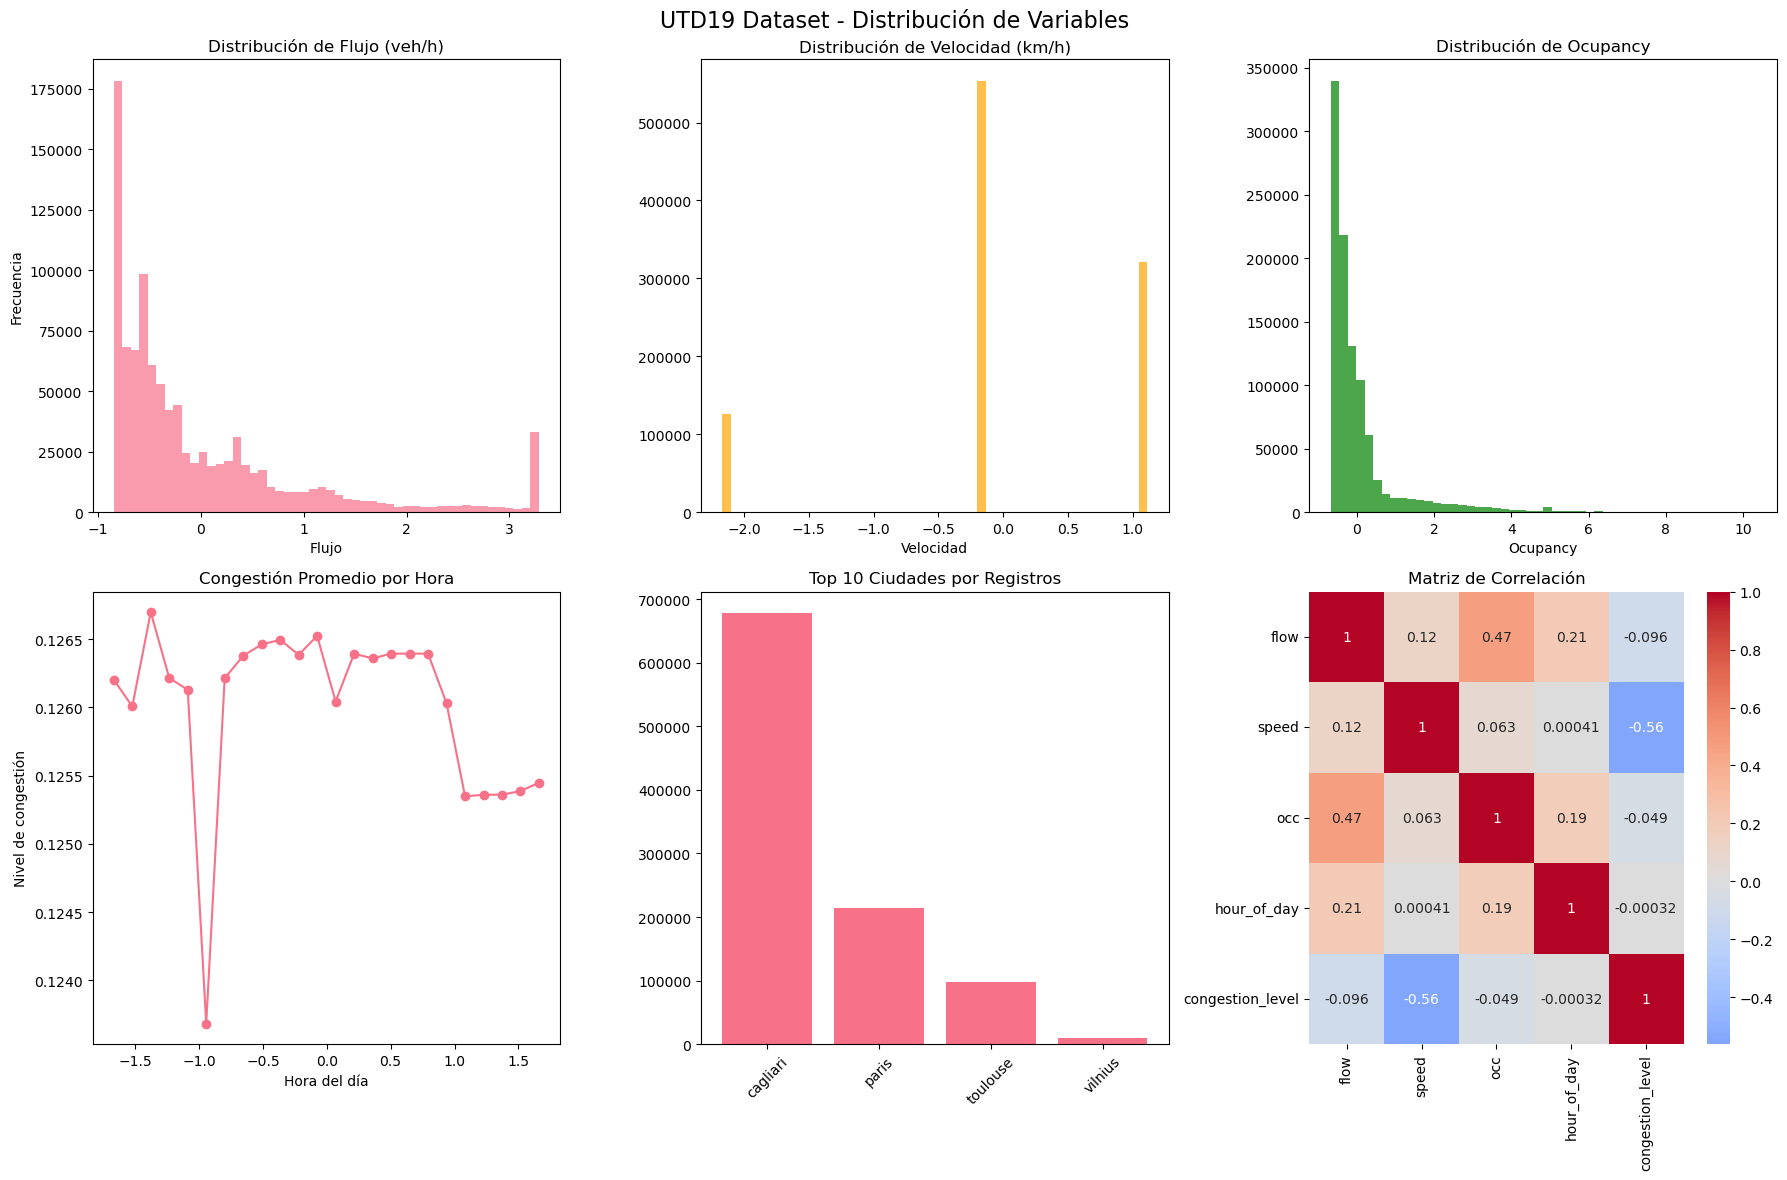

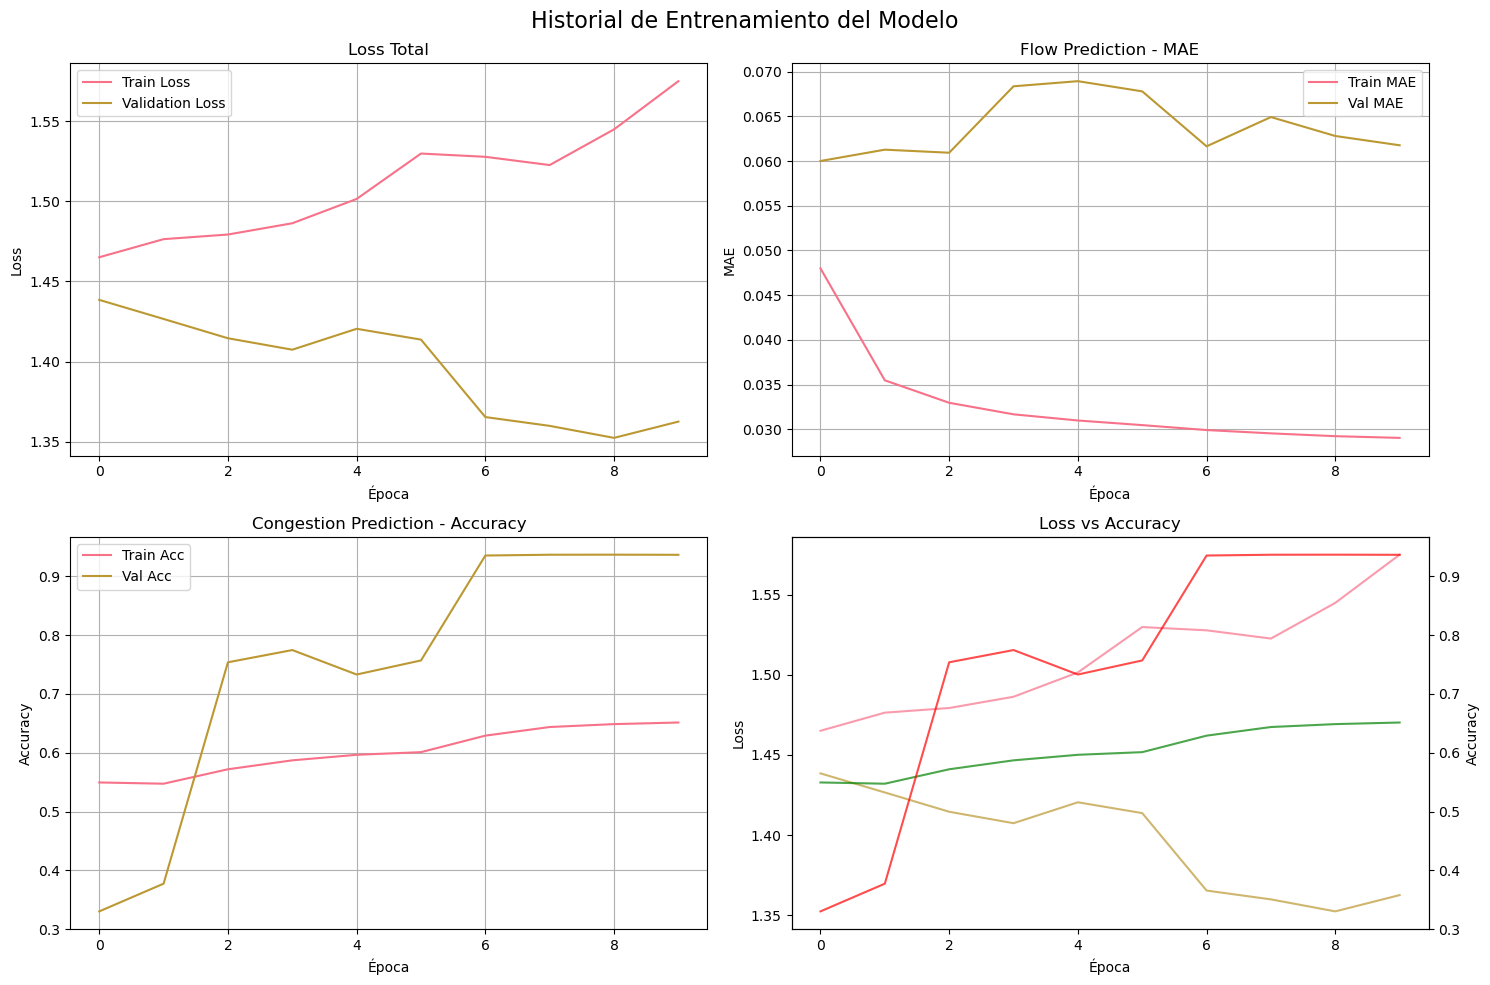

🔮 Generando predicciones para evaluación...
6250/6250 [==============================] - 17s 3ms/step
Predicciones (flow) escaladas: [[0.189373  ]
 [0.07401741]
 [0.17989132]
 [0.7162404 ]
 [0.06513462]]
Predicciones (flow) reales: [[-0.06257169]
 [-0.53924423]
 [-0.10175192]
 [ 2.1145506 ]
 [-0.5759497 ]]
MAPE del flujo en test: 44.99%

MÉTRICAS FINALES:
Precision: 0.882
Recall: 0.936
F1-Score: 0.908


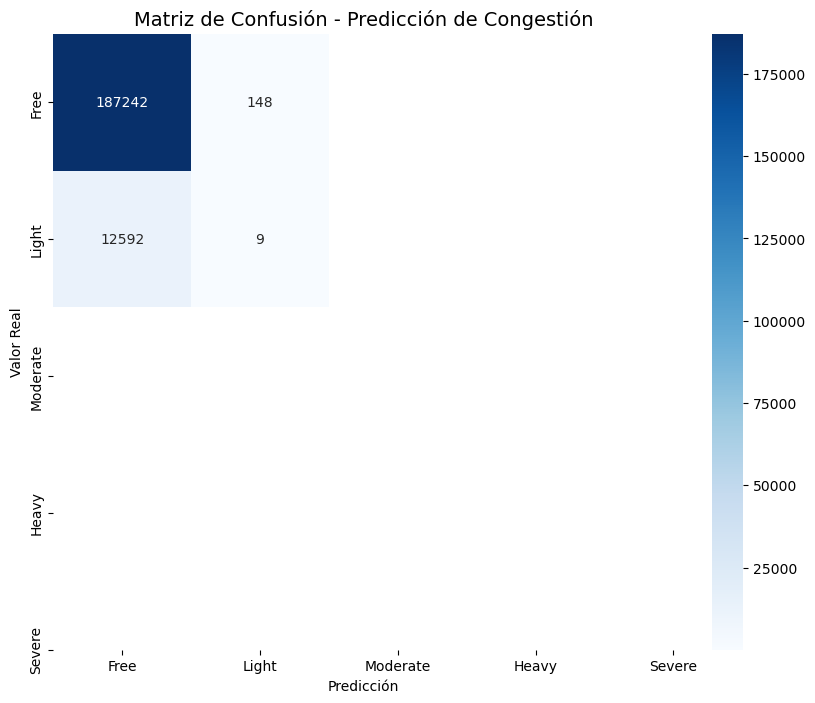


📊 REPORTE DE CLASIFICACIÓN:


ValueError: Number of classes, 2, does not match size of target_names, 5. Try specifying the labels parameter

In [11]:
if __name__ == "__main__":
    model, history, scaler, detector_mapping, metrics_report = main_implementation()
    print("\n🎉 IMPLEMENTACIÓN UTD19 COMPLETADA!")
    print("="*60)
    print("📈 RESULTADOS DEL CASO DE ESTUDIO:")
    print(f"  🎯 Precisión predicción: {metrics_report['summary']['prediction_accuracy']:.1%}")
    print(f"  ⏱️ Reducción tiempo viaje: {metrics_report['summary']['travel_time_reduction_pct']:.1f}%") 
    print(f"  ⛽ Ahorro combustible: {metrics_report['summary']['fuel_savings_pct']:.1f}%")
    print(f"  😊 Satisfacción usuario: {metrics_report['summary']['user_satisfaction']:.1f}/100")
    print(f"  💰 ROI: {metrics_report['economic_impact']['roi_years']:.1f} años")
    print("\n🚦 Sistema listo para optimización de tráfico en tiempo real!")